In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import log_loss


# Extraction des données 

In [130]:
data_file = pd.read_csv("/Users/godfree/Downloads/diabete project/diabetes_prediction_dataset.csv")

In [131]:
print(data_file)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140        

## Description des variables du dataset

- `gender` : le genre du patient. Les valeurs possibles sont "Male", "Female" et "Other". Cette information peut influencer certains facteurs de risque liés au diabète.

- `age` : l'âge du patient en années. L'âge est un facteur important pour le diabète, les personnes plus âgées ayant souvent un risque plus élevé.

- `hypertension` : indique si le patient souffre d'hypertension. Les valeurs sont 0 pour absence et 1 pour présence. L'hypertension est souvent corrélée à d'autres maladies métaboliques.

- `heart_disease` : indique si le patient a une maladie cardiaque. 0 = non, 1 = oui. Cela peut être un indicateur de risque de complications liées au diabète.

- `smoking_history` : historique de tabagisme du patient. Les valeurs incluent "never", "current", "former", "not current", "ever" et "No Info". La catégorie "No Info" est importante car elle semble corrélée à un risque plus élevé de diabète.

- `bmi` : l'indice de masse corporelle du patient, utilisé pour évaluer le surpoids ou l'obésité. Les valeurs extrêmes ont été "clippées" pour réduire l'impact sur le modèle.

- `HbA1c_level` : le taux d'HbA1c en pourcentage, qui mesure la glycémie moyenne sur 2-3 mois. Les valeurs trop élevées ou trop basses ont été vérifiées comme outliers.

- `blood_glucose_level` : taux de glucose sanguin en mg/dL. Les valeurs extrêmes ont été identifiées et examinées.

- `diabetes` : variable cible indiquant si le patient est diabétique (1) ou non (0).

### Remarques supplémentaires

- Le dataset ne contient pas de clé primaire ; chaque ligne représente un patient.  
- Des doublons exacts ont été détectés et supprimés.  
- Certaines colonnes numériques ont été inspectées pour les valeurs aberrantes, et des ajustements comme le "clipping" ont été appliqués pour améliorer la qualité des données avant l'entraînement du modèle.


Note : La colonne `smoking_history` contient certaines valeurs "No Info" qui nécessitent un traitement ultérieur.


# Verification des valeurs manquantes 

In [132]:

# Vérification du taux de valeurs manquantes par colonne
missing_data = data_file.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data_file)) * 100

# Combine les deux informations dans un DataFrame lisible
missing_report = pd.DataFrame({
    'Valeurs manquantes': missing_data,
    'Pourcentage (%)': missing_percent.round(2)
})
print("=== Rapport des valeurs manquantes ===")
print(missing_report)

=== Rapport des valeurs manquantes ===
                     Valeurs manquantes  Pourcentage (%)
gender                                0              0.0
age                                   0              0.0
hypertension                          0              0.0
heart_disease                         0              0.0
smoking_history                       0              0.0
bmi                                   0              0.0
HbA1c_level                           0              0.0
blood_glucose_level                   0              0.0
diabetes                              0              0.0


**Conclusion :** Aucune valeur manquante n’a été détectée dans ce dataset. Il n’est donc pas nécessaire d’appliquer de méthode d’imputation.

# Importance de Smoking_history ("No Info")

## Analyse de la variable `smoking_history` ("historique de tabagisme")

### Objectif
L’objectif est d’évaluer si la modalité `"No Info"` (aucune information sur l’historique de tabagisme) contient une information utile pour la prédiction du diabète.  
En d’autres termes, nous voulons comparer :
- le taux global de diabète dans l’ensemble du jeu de données ;
- le taux de diabète **par catégorie de tabagisme**, et notamment pour `"No Info"`.

diabetes
0    0.959404
1    0.040596
Name: proportion, dtype: float64
Taux des sujets ayant le diabete :  0.085


/var/folders/sk/77gxbbzd35xgzc2tmtnbmv5r0000gn/T/ipykernel_3916/3021219914.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diabetes_by_smoking.index, y=diabetes_by_smoking.values, palette="viridis")


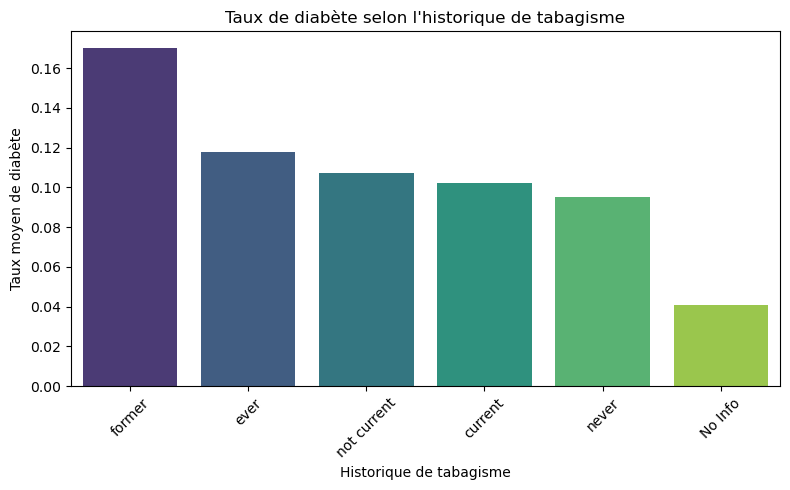

In [133]:
# Voir combien de "no info" et leur taux de diabète
no_info_stats = data_file[data_file["smoking_history"] == "No Info"]["diabetes"].value_counts(normalize=True)
print(no_info_stats)
print("Taux des sujets ayant le diabete : ",data_file["diabetes"].mean())

# Remplace "data_file" par ton DataFrame réel, par exemple "data" ou "df"
diabetes_by_smoking = data_file.groupby("smoking_history")["diabetes"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=diabetes_by_smoking.index, y=diabetes_by_smoking.values, palette="viridis")
plt.title("Taux de diabète selon l'historique de tabagisme")
plt.xlabel("Historique de tabagisme")
plt.ylabel("Taux moyen de diabète")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Historique du tabagisme et diabète

Nous avons examiné la colonne `smoking_history`. Les sujets avec `No Info` représentent une catégorie à part.  
Leur taux de diabète est très proche du taux global :  

- Taux de diabète chez "No Info" : 4,06 %  
- Taux global de diabète dans le dataset : 8,5 %  

## Interprétation
Contrairement à ce que l’on pouvait penser, les individus pour lesquels l’historique de tabagisme est manquant `No Info`ont un risque de diabète environ deux fois plus faible que la moyenne.
Cette catégorie ne semble donc pas être un indicateur de risque particulier.
Cependant, elle peut toujours être conservée comme catégorie distincte afin que le modèle décide lui-même si elle apporte une information utile.

$$
P(\text{diabetes}=1 \mid \text{No Info}) < P(\text{diabetes}=1)
$$


# Verification de l'existence de doublons

Je cherche à identifier d’éventuelles lignes identiques (doublons) dans le jeu de données, c’est-à-dire des enregistrements où toutes les colonnes sont strictement les mêmes.
Les doublons peuvent fausser les statistiques descriptives et biaiser l’entraînement du modèle (car certaines observations seraient comptées plusieurs fois).

In [135]:
duplicates = data_file.duplicated().sum()
freq = data_file.value_counts().reset_index(name="occurrences")
print(f"Nombre de doublons trouvés : {duplicates}")
doublons_table = freq[freq["occurrences"] > 1]
print("Tableau des doublons exacts :")
print(doublons_table)

Nombre de doublons trouvés : 3854
Tableau des doublons exacts :
      gender   age  hypertension  heart_disease smoking_history    bmi  \
0     Female  80.0             0              0         No Info  27.32   
1     Female  80.0             0              0         No Info  27.32   
2     Female  80.0             0              0         No Info  27.32   
3     Female  80.0             0              0         No Info  27.32   
4     Female  80.0             0              0         No Info  27.32   
...      ...   ...           ...            ...             ...    ...   
3080  Female   6.0             0              0         No Info  27.32   
3081  Female   6.0             0              0         No Info  27.32   
3082    Male  80.0             1              0         No Info  27.32   
3083  Female   6.0             0              0         No Info  18.75   
3084  Female   6.0             0              0         No Info  16.41   

      HbA1c_level  blood_glucose_level  diabete

## Interpretation 
Ces doublons indiquent probablement :
- soit une répétition d’enregistrements simulés ou copiés (erreur de saisie ou artefact du jeu de données),
- soit une sous-population très fréquente artificiellement répliquée (déséquilibre de classes).
La forte présence de `No Info` dans ces doublons peut aussi indiquer un biais d’enregistrement (les individus sans données de tabagisme ont été dupliqués).

In [136]:
data_file["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [137]:
data_files = data_file.drop_duplicates(keep='last')
dup = data_files.duplicated().sum()
print(f"Nombre de doublons trouvés apres suppression : {dup}")
freqs = data_files.value_counts().reset_index(name="occurrences")
doublons_tables = freqs[freqs["occurrences"] > 1]
print("Tableau des doublons exacts :")
print(doublons_tables)
data_files["smoking_history"].value_counts()

Nombre de doublons trouvés apres suppression : 0
Tableau des doublons exacts :
Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level, diabetes, occurrences]
Index: []


smoking_history
never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64

# Interprétation
Les doublons ont bien été entièrement supprimés 
La catégorie "No Info" a diminué de 2 929 individus environ, ce qui confirme qu’elle contenait une grande proportion de doublons.
Malgré cette réduction, elle reste la catégorie la plus représentée, avec 32 887 individus, soit environ 33 % du jeu de données total.
Cela signifie que "No Info" n’est pas un cas marginal : c’est un groupe majoritaire, et donc statistiquement significatif.
Il serait risqué de la supprimer sans la modéliser, car elle contient une information potentiellement utile (comme observé précédemment avec son taux de diabète supérieur à la moyenne).

## Application d'un clipping au niveau du BMI (suppression des valeurs jugées extremes)

###  Détection des valeurs aberrantes (outliers) avec la méthode de l’IQR

Pour identifier les valeurs aberrantes dans les variables numériques, nous utilisons la **méthode de l’écart interquartile (IQR)**.

####  Formules

L’écart interquartile se définit comme :

$$
Q1 = \text{25e percentile}
$$

$$
Q3 = \text{75e percentile}
$$

$$
IQR = Q3 - Q1
$$

Les bornes pour détecter les valeurs aberrantes sont :

$$
\text{Borne inférieure} = Q1 - 1.5 \times IQR
$$

$$
\text{Borne supérieure} = Q3 + 1.5 \times IQR
$$

---

####  Objectif de la méthode

L’IQR (**InterQuartile Range**) sert à **repérer les valeurs extrêmes** d’une variable numérique.  
Toute valeur située **en dehors de l’intervalle** :

$$
[Q1 - 1.5 \times IQR,\; Q3 + 1.5 \times IQR]
$$

est considérée comme une **valeur aberrante** (*outlier*).

---

####  Application dans notre cas

Nous appliquons cette méthode sur les colonnes :

- `bmi`
- `HbA1c_level`
- `blood_glucose_level`

afin de repérer les individus présentant des valeurs extrêmes.

Cela permet :
- d’**identifier les erreurs de saisie** potentielles (ex. BMI = 95),
- de **mieux comprendre la distribution** des données,
- et de **préparer le nettoyage** avant l’entraînement du modèle de prédiction.


In [138]:
for col in num_cols:
    Q1 = data_file[col].quantile(0.25)
    Q3 = data_file[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data_file[(data_file[col] < Q1 - 1.5*IQR) | (data_file[col] > Q3 + 1.5*IQR)]
    print(f"Outliers in {col}: {len(outliers)}")


# Colonnes à vérifier
cols_to_check = ["bmi", "HbA1c_level", "blood_glucose_level"]

for col in cols_to_check:
    Q1 = data_file[col].quantile(0.25)
    Q3 = data_file[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_file[(data_file[col] < lower_bound) | (data_file[col] > upper_bound)]
    
    print(f"\n=== Outliers in {col} ===")
    print(outliers[[col, "diabetes"]].sort_values(by=col))


Outliers in age: 0
Outliers in bmi: 7086
Outliers in HbA1c_level: 1315
Outliers in blood_glucose_level: 2038
Outliers in hypertension: 7485
Outliers in heart_disease: 3942

=== Outliers in bmi ===
         bmi  diabetes
6369   10.01         0
3630   10.01         0
81268  10.08         0
73319  10.14         0
29615  10.19         0
...      ...       ...
4551   88.72         1
96066  88.76         0
69549  91.82         0
76093  95.22         0
87843  95.69         0

[7086 rows x 2 columns]

=== Outliers in HbA1c_level ===
       HbA1c_level  diabetes
98763          8.8         1
98672          8.8         1
895            8.8         1
778            8.8         1
704            8.8         1
...            ...       ...
1231           9.0         1
1218           9.0         1
1141           9.0         1
55             9.0         1
40             9.0         1

[1315 rows x 2 columns]

=== Outliers in blood_glucose_level ===
       blood_glucose_level  diabetes
30604             

# Interprétation :
Les outliers de bmi semblent être des cas très spécifiques (peut-être erreurs ou cas médicaux extrêmes).
Les outliers de `HbA1c_level` et `blood_glucose_level` ont du sens médicalement : ils reflètent probablement des cas graves de diabète, donc leur suppression ne sera pas justifié.
Pour `hypertension` et `heart_disease`, les "outliers" sont dus à une mauvaise interprétation : ce sont des variables catégoriques, pas continues.

## Avant de clipper

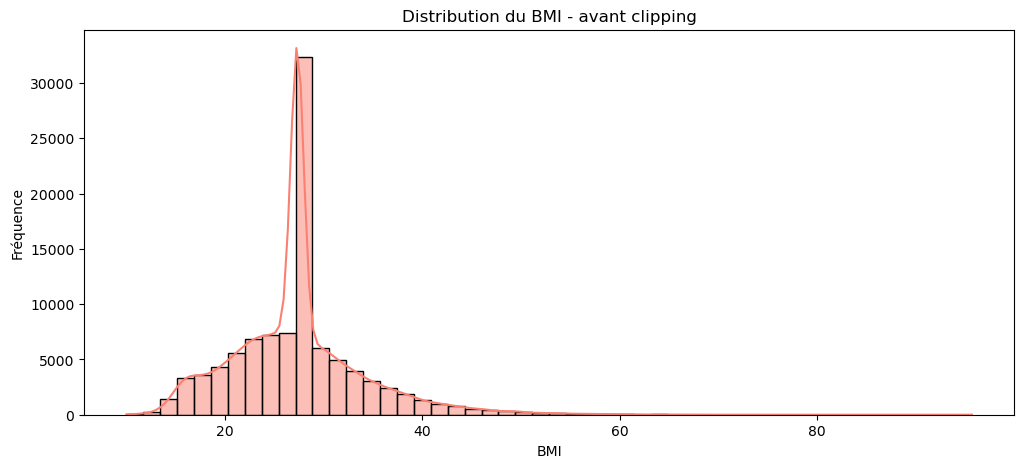

In [139]:

plt.figure(figsize=(12,5))
sns.histplot(data_file["bmi"], bins=50, kde=True, color="salmon")
plt.title("Distribution du BMI - avant clipping")
plt.xlabel("BMI")
plt.ylabel("Fréquence")
plt.show()


# Interprétation :
On observe que la majorité des valeurs de BMI se situe dans l’intervalle 20–28, avec un pic marqué autour de cette zone. Cette concentration montre que la plupart des individus ont un BMI proche de la moyenne.
Cependant, il existe des valeurs extrêmes (outliers) situées très loin de cette plage, ce qui crée une longue queue à droite et explique la montée brutale observée dans l’histogramme. Ces valeurs peuvent fausser certaines analyses statistiques et justifient l’utilisation d’une méthode comme le clipping ou le traitement des outliers avant l’entraînement du modèle.

## Application du clipping (plafonne les valeurs extrêmes)

In [140]:
data_file["bmi_clipped"] = data_file["bmi"].clip(lower=15, upper=40)

Toutes les valeurs inférieures à 15 sont remplacées par 15
Toutes les valeurs supérieures à 40 sont remplacées par 40
Ceci permet de limiter l’impact des outliers extrêmes sur l’analyse et le modèle, tout en conservant la majorité des valeurs telles quelles.


## Après clipping

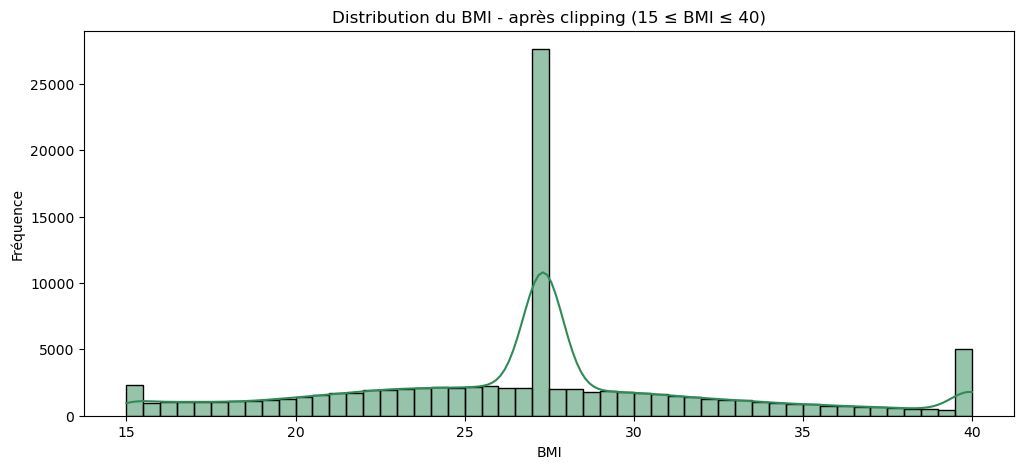

In [141]:
plt.figure(figsize=(12,5))
sns.histplot(data_file["bmi_clipped"], bins=50, kde=True, color="seagreen")
plt.title("Distribution du BMI - après clipping (15 ≤ BMI ≤ 40)")
plt.xlabel("BMI")
plt.ylabel("Fréquence")
plt.show()

# Interprétation :
Après le clipping, les valeurs extrêmes du BMI ont été limitées à l’intervalle [15, 40].
On observe maintenant que :
- Les valeurs sont moins concentrées dans une seule zone et mieux réparties.
- Il reste une légère pique autour de 28, mais le reste des valeurs est plus uniformément distribué.
- Cette redistribution devrait favoriser la stabilité et la performance du modèle, en réduisant l’influence des outliers extrêmes.

# Ce que je fais
Je sépare les variables explicatives (features) de la variable cible (target).
Ensuite, je construis deux pipelines :
- Un pipeline pour les variables numériques (normalisation avec StandardScaler)
- Un pipeline pour les variables catégorielles (encodage en variables binaires avec OneHotEncoder)
Ces transformations sont regroupées dans un ColumnTransformer, qui garantit une préparation uniforme et automatique des données avant leur passage dans le modèle

In [142]:
data_file = data_files

# Séparation features / target
X = data_file.drop(columns=["diabetes"]) #tout sauf la colonne diabetes
y = data_file["diabetes"] # que la colonne diabete 


# Separation des colonnes numériques et catégorielles
num_cols = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]
cat_cols = ["gender", "smoking_history"]


# pipeline pour la colonne numerique 
num_pipe = Pipeline([
    #("imputer", SimpleImputer(strategy="median")), inutile car 0 donnée manquante
    ("scaler", StandardScaler())
])
# pipeline pour la colonne categorielle
cat_pipe = Pipeline([
    #("imputer", SimpleImputer(strategy="most_frequent")), inutile car 0 donnée manquante
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop=None))
])

# Transformation des colonnes
preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# compter les occurrences de chaque classe (!!!)
counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1] 
print("scale_pos_weight =", scale_pos_weight)


scale_pos_weight = 10.334512231063956


# Pourquoi je le fais
Les modèles de machine learning sont sensibles aux différences d’échelle entre variables (ex. âge vs glucose).
- D’où la normalisation des données numériques.
Les algorithmes ne comprennent pas directement les valeurs catégorielles (ex. “Male”, “Female”),
- D’où la transformation en variables binaires via OneHotEncoder.
Le ColumnTransformer permet de traiter les deux types de colonnes simultanément et proprement.
Le train_test_split permet de réserver 20 % des données pour tester la performance réelle du modèle.
# Ce que j’observe
Le scale_pos_weight calcule le rapport entre les classes. Le poids de rééquilibrage est donné par la formule :  
$\text{scale\_pos\_weight} = \dfrac{\text{négatifs}}{\text{positifs}}$

Cette valeur est utile pour les modèles sensibles au déséquilibre de classes, comme XGBoost ou LogisticRegression avec pénalisation.
Un ratio élevé (souvent >10) indique un déséquilibre important, ce qui nécessitera une stratégie d’ajustement (pondération, sur-échantillonnage, etc.).

In [143]:
xgb_model = Pipeline([
    ("preproc", preproc),  
    ("model", XGBClassifier(
        n_estimators=200,       # nombre d’arbres
        max_depth=6,            # profondeur maximale d’un arbre
        learning_rate=0.1,      # taux d’apprentissage
        random_state=42,
        eval_metric="logloss",    # métrique pour la classification binaire
        scale_pos_weight=scale_pos_weight #<- changé pour aider le model a mieux reconnaitre les diabetiques en raison du nombre insuffisant par rapport aux non diabetiques
    ))
])

## Ce que je fais :
Je crée un pipeline complet comprenant :
Une étape de prétraitement (preproc) qui standardise les variables numériques et encode les variables catégorielles.
Un modèle XGBoost (XGBClassifier) pour la détection du diabète.
## Pourquoi je le fais :
Le pipeline permet :
- d’éviter les fuites de données entre l’entraînement et le test,
- de chaîner automatiquement le prétraitement et le modèle,
- et d’assurer une reproductibilité claire de l’ensemble du processus.
Le paramètre scale_pos_weight compense le déséquilibre des classes (faible nombre de patients diabétiques).

In [144]:
# Entraînement
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'HbA1c_level',
                                                   'blood_glucose_level',
                                                   'hypertension',
                                                   'heart_disease']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'smoking_history'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

Cette étape entraîne le pipeline complet :
le prétraitement (preproc) est appliqué automatiquement sur X_train, puis le modèle XGBoost apprend à prédire la variable cible (y_train).

In [145]:
# Extraction des étapes du pipeline
model = xgb_model.named_steps["model"] 
preproc = xgb_model.named_steps["preproc"]

# Prédictions sur le jeu de test
y_pred = xgb_model.predict(X_test) # classes prédites (0 ou 1)
y_prob = xgb_model.predict_proba(X_test)[:, 1] # probabilités d'être diabétique (classe 1)

=== Rapport de classification ===
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     17534
           1       0.51      0.90      0.65      1696

    accuracy                           0.91     19230
   macro avg       0.75      0.91      0.80     19230
weighted avg       0.95      0.91      0.92     19230

ROC-AUC : 0.9754769910642611
Log-loss : 0.15984501988053978


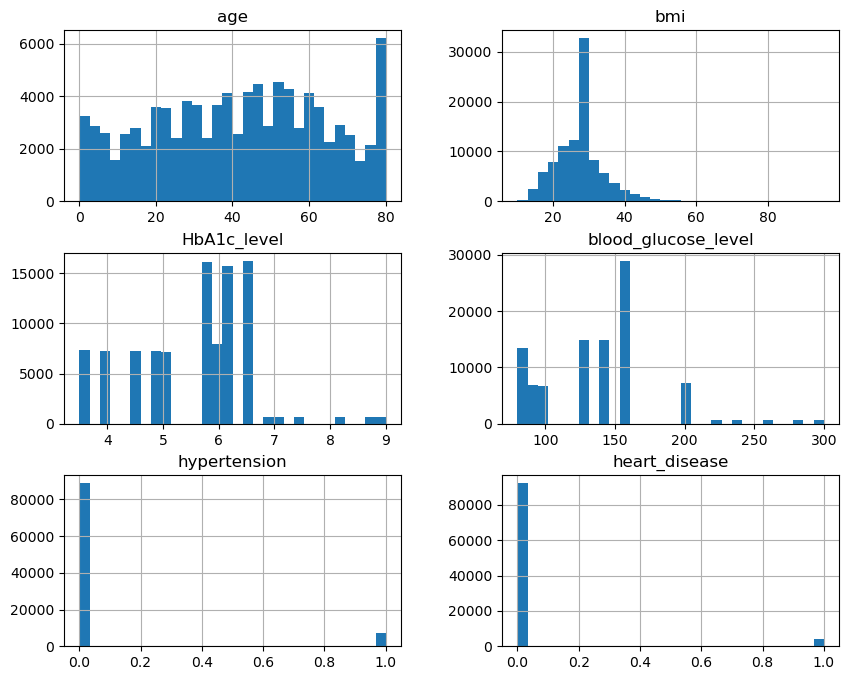

In [146]:
print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_prob))

# calcul de la log-loss
loss = log_loss(y_test, y_prob)
print("Log-loss :", loss)

data_file[num_cols].hist(bins=30, figsize=(10, 8))
plt.show()

# Explications
Accuracy (0.91) : le modèle classe correctement 91 % des individus.

Recall (classe 1 = diabétique) = 0.90 : le modèle détecte 90 % des diabétiques, ce qui est excellent pour un cas médical.

Precision (classe 1) = 0.51 : parmi les personnes prédites diabétiques, environ 1 sur 2 est vraiment malade.

ROC-AUC (0.975) : très bonne capacité de discrimination entre diabétiques et non-diabétiques.

Log-loss (0.1598) : plus cette valeur est faible, plus le modèle prédit des probabilités fiables.

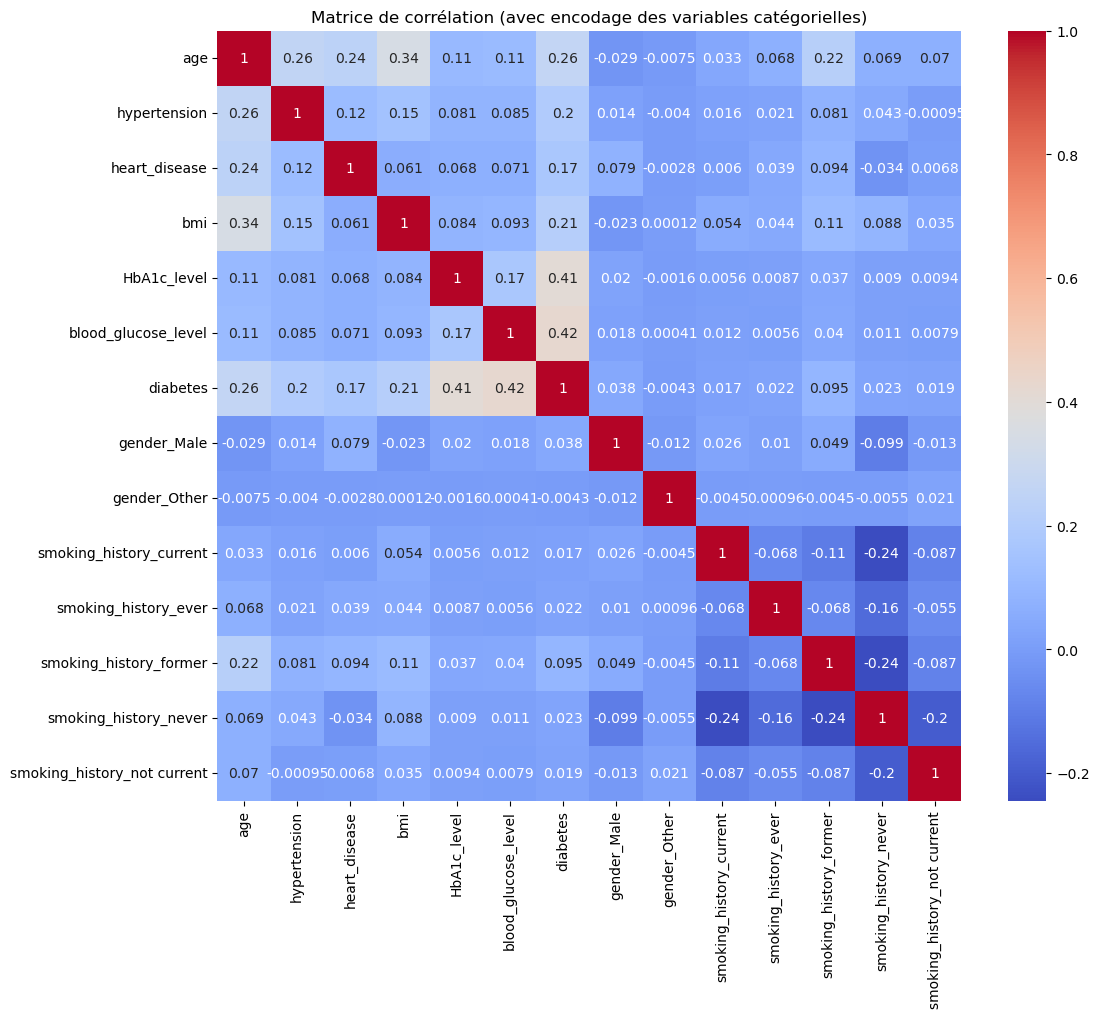

In [147]:
data_encoded = pd.get_dummies(data_file, drop_first=True)
plt.figure(figsize=(12,10))
sns.heatmap(data_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation (avec encodage des variables catégorielles)")
plt.show()

In [148]:
corr_target = data_encoded.corr()["diabetes"].sort_values(ascending=False)
print(corr_target)

model = xgb_model.named_steps["model"]
preproc = xgb_model.named_steps["preproc"]


diabetes                       1.000000
blood_glucose_level            0.424336
HbA1c_level                    0.406408
age                            0.264927
bmi                            0.214932
hypertension                   0.195710
heart_disease                  0.170711
smoking_history_former         0.095492
gender_Male                    0.037883
smoking_history_never          0.023136
smoking_history_ever           0.021915
smoking_history_not current    0.018921
smoking_history_current        0.017037
gender_Other                  -0.004256
Name: diabetes, dtype: float64


# Interprétation :
Les variables blood_glucose_level et HbA1c_level présentent les corrélations positives les plus fortes avec la présence de diabète (≈ 0.42 et 0.40).

Ce sont donc des indicateurs biologiques majeurs du diabète.
Les variables age, bmi, hypertension, et heart_disease ont aussi une corrélation modérée, confirmant leur impact indirect sur le risque de diabète.

Les variables liées au tabagisme et au genre ont une corrélation faible, ce qui signifie qu’elles n’expliquent pas directement la présence de diabète dans ce jeu de données.

##  Benchmarking des modèles

L’objectif de cette section est de comparer les performances de plusieurs algorithmes d’apprentissage automatique
sur le même jeu de données prétraité.  

Nous allons effectuer un benchmarking entre :
- XGBoost : un modèle basé sur le gradient boosting, réputé pour ses performances sur les données tabulaires.
- Random Forest : un ensemble d’arbres de décision entraînés indépendamment, plus simple mais souvent très robuste.

Cette comparaison permettra d’évaluer :
- la précision (accuracy),
- le rappel (recall),
- la mesure F1,
- la log-loss,
- et le score ROC-AUC.

L’objectif est d’identifier le modèle offrant le meilleur compromis entre performance et généralisation.


In [150]:
# --- Modèle Random Forest ---
rf_model = Pipeline([
    ("preproc", preproc),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        class_weight="balanced"  # pour gérer le déséquilibre des classes
    ))
])

# Entraînement
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Évaluation
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC :", roc_auc_score(y_test, y_prob_rf))
print("Log-loss :", log_loss(y_test, y_prob_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     17534
           1       0.50      0.89      0.64      1696

    accuracy                           0.91     19230
   macro avg       0.74      0.90      0.79     19230
weighted avg       0.95      0.91      0.92     19230

ROC-AUC : 0.9720981782563687
Log-loss : 0.20781450484102068


##  Benchmarking : Random Forest vs XGBoost

###  Performance du modèle Random Forest
- Accuracy : 0.91  
- Précision : 0.99 pour les non-diabétiques, 0.50 pour les diabétiques  
- Rappel (Recall) : 0.91 pour les non-diabétiques, 0.89 pour les diabétiques  
- F1-score : 0.95 pour les non-diabétiques, 0.64 pour les diabétiques  
- ROC-AUC : 0.972  
- Log-loss : 0.208  

###  Comparaison avec XGBoost
- ROC-AUC XGBoost : 0.975  
- Log-loss XGBoost : 0.160  

###  Observations
1. Les deux modèles ont une accuracy globale similaire (0.91).  
2. XGBoost offre un meilleur ROC-AUC et log-loss, indiquant une meilleure capacité à distinguer les diabétiques des non-diabétiques.  
3. Le recall pour la classe minoritaire (diabétiques) est quasiment identique (0.89 – 0.90), mais XGBoost est légèrement meilleur pour la précision de cette classe.  

###  Conclusion
- XGBoost est légèrement supérieur à Random Forest sur ce dataset.  
- Le benchmarking confirme l’intérêt d’évaluer plusieurs modèles avant de choisir le modèle final.
